# Introduction to Problem

The problem addressed here concerns the 1999 Playstation video game Monster Rancher 2. In the video game, players breed and battle monsters, which have a main type, a sub type, and stats such as Life, Power, Intelligence, Skill, Speed, and Defense (Lif, Pow, Int, Ski, Spd, Def for short), as well as other data. There is an in-game mechanic where players are able to combine monsters to get a new monster, which we'll refer to as the offspring or the result. This is done at the Lab. 

The mechanics of the Lab are mostly uncovered, except for occasional weird exceptions. An in-depth explanation of the lab mechanics can be found at https://gamefaqs.gamespot.com/ps/197977-monster-rancher-2/faqs/41787. In brief, monster stats are multiplied by a growth factor for each respective stat based on main and sub monster type. According to the guide, the product is capped at $999$. However, I had more luck with my calculations if there is no cap. These products are ordered from highest to lowest, with the base stats being used to break any ties. The number of matches in the order determine what Dadge, the character running the lab, says. For some reason, my game appears to differ from the guide. My order appears to be

* 0 stats = Up to You
* 1 stat = Not Good
* 2 stats = Unsure
* 3 stats = Fine
* 4 stats = Good
* 6 stats = Great

If the order of the stats match (and the order of the offspring stat also matches), then a stat boost is given to the offspring and the amount of boost is partially determined by a random number generator (seen in the data itself). This is not the case we are concerned with here.

This notebook's aim is less practical towards optimal game-play. I've noticed that if the monsters used to create the offspring do not match in a stat's position, then when the offspring is the same, the stat number is the same. This indicates that there is an underlying formula that determines the offspring's stat, and then stat boosts are added if applicable. Instead of finding the optimal way to combine monsters, which has already been done, our aim is to first uncover the underlying formula when stats do not match.

Here is a brief outline of how this will be handled. I have compiled data from near 700 combinations done at the lab, recording vital statistics that could be involved. The collection of these can be read in the documentation of the data files. I believe that the same formula governs all stats, so we will develop the formula using only data from the Lif stat. Once the formula is found, the test data will be the other five stats: Pow, Int, Ski, Spd, and Def.

Note that we exclude any parents whose stat order matches in a particular stat. This is being extra cautious to avoid the weird exceptions mentioned above where the stat order calculation doesn't work.

In [1]:
#Data handling
import numpy as np
import pandas as pd

#Graphs
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

#Metrics
from sklearn.metrics import mean_squared_error

#Model selection
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# Data Cleaning

There are a few columns that we need, but were not thought of until after the data was collected. Duplicates are eliminated and more columns are created by combining some preexisting columns.

In [2]:
#Import data for the in-game Lif stat
df_lif = pd.read_csv('Lif_Data_1.csv')

#Drop duplicate rows
df_lif.drop_duplicates(inplace = True)
df_lif.head()

,Main_Stat,Main_Growth,Main_Base,Main_Base_Rank,Main_True_Rank,Sub_Stat,Sub_Growth,Sub_Base,Sub_Base_Rank,Sub_True_Rank,...,Result_Growth,Result_Base,Result_Base_Rank,Result_True_Rank,Main_Result,Sub_Result,Type,Main,Sub,Rarity
0,999,5,170,1,1,999,3,100,5,5,...,5,170,1,1,1,0,Not Good,Cpandora,Cpandora,38
2,999,5,170,1,1,999,3,100,5,5,...,3,100,5,5,0,1,Not Good,Durahan,Joker,29
3,999,5,170,1,1,999,3,100,5,5,...,3,120,3,4,0,0,Not Good,Joker,Joker,12
7,999,3,100,5,5,999,5,170,1,1,...,3,100,4,4,0,0,Not Good,Durahan,Durahan,21
8,999,3,100,5,5,999,5,170,1,1,...,3,100,5,5,1,0,Not Good,Durahan,Joker,48


In [3]:
#Function for rarity levels
def rarity_levels(num):
    if num <= 3:
        return 1
    elif num <= 7:
        return 2
    elif num <= 14:
        return 3
    elif num <= 29:
        return 4
    elif num <= 49:
        return 5
    else:
        return 6
    
#Function to check if a random number is added to the stat  
def boost_check(row):
    if (row['Main_True_Rank'] == row['Sub_True_Rank']):
        return 1
    else:
        return 0

#Creates the extra columns needed to do the analysis
def add_columns(df, no_randoms = True):
    
    #Calculates differences from base stats
    df['Result_Dif'] = df['Result_Stat'] - df['Result_Base']
    df['Main_Dif'] = df['Main_Stat'] - df['Main_Base']
    df['Sub_Dif'] = df['Sub_Stat'] - df['Sub_Base']
    
    #Transforms rarity into categorical data
    df['Rarity_Level'] = df.Rarity.apply(rarity_levels)
    
    #Create feature to track if random number is added
    df['Boost'] = df.apply(boost_check, axis = 1)
    
    #Drop features that were used in calculating the difference features
    df.drop(columns = ['Result_Stat', 'Result_Base', 'Main_Stat', 'Main_Base', 'Sub_Stat', 'Sub_Base'], inplace = True)
    
    if no_randoms == True:
        return df[df.Boost == 0]
    else:
        return df

In [4]:
#Add additional columns to DataFrame
df_lif = add_columns(df_lif)

The Rarity_Level feature is worth explaining here. Below are five samples from the dataframe with the same parents, and five different children. The least rare, the Dragon/Kato gets $60$ added to its base Lif. From there, the amount added increases by $12$ as the Rarity_Level becomes smaller.

The next sample demonstrates how the Rarity feature needs to be a step function. Observe that $9$ and $14$ both result in $70$ being added, while $22$ and $29$ both result in $60$ being added. Again, there is a linear decrease as the Rarity_Level increases. The slope of the decrease appears linked to other features as well, an early clue that there is feature interaction. It should be noted that although in these examples the decrease is linear, that should not be assumed to always be the case.

There is sufficient data to create most of the Rarity_Levels seen in the Rarity_Level feature. However, higher cut-offs were determined without solid evidence. These were selected based on educated guesses (and the changes improved the results). Since the Rarity feature is really a percentage, then it's unusual to see both a number in the $40$s and a number in the $30$s in a single combination.

In [5]:
df_lif.iloc[502:507]

,Main_Growth,Main_Base_Rank,Main_True_Rank,Sub_Growth,Sub_Base_Rank,Sub_True_Rank,Result_Growth,Result_Base_Rank,Result_True_Rank,Main_Result,Sub_Result,Type,Main,Sub,Rarity,Result_Dif,Main_Dif,Sub_Dif,Rarity_Level,Boost
667,3,4,4,2,5,5,3,4,4,1,0,Up to You,Dragon,Golem,16,72,800,800,4,0
668,3,4,4,2,5,5,2,6,6,0,0,Up to You,Kato,Dragon,5,96,800,800,2,0
669,3,4,4,2,5,5,2,5,5,0,1,Up to You,Kato,Gali,2,108,800,800,1,0
670,3,4,4,2,5,5,3,4,4,0,0,Up to You,Golem,Gali,12,84,800,800,3,0
671,3,4,4,2,5,5,3,6,6,0,0,Up to You,Dragon,Kato,33,60,800,800,5,0


In [6]:
df_lif.loc[493:497]

,Main_Growth,Main_Base_Rank,Main_True_Rank,Sub_Growth,Sub_Base_Rank,Sub_True_Rank,Result_Growth,Result_Base_Rank,Result_True_Rank,Main_Result,Sub_Result,Type,Main,Sub,Rarity,Result_Dif,Main_Dif,Sub_Dif,Rarity_Level,Boost
493,2,5,5,5,1,1,4,1,1,0,0,Up to You,Plant,Zuum,7,80,586,839,2,0
494,2,5,5,5,1,1,3,3,3,0,0,Up to You,Monol,Plant,28,60,586,839,4,0
495,2,5,5,5,1,1,4,2,1,0,0,Up to You,Zuum,Plant,22,60,586,839,4,0
496,2,5,5,5,1,1,4,1,1,0,0,Up to You,Plant,Monol,14,70,586,839,3,0
497,2,5,5,5,1,1,2,5,5,1,0,Up to You,Monol,Zuum,9,70,586,839,3,0


# Feature Selection - The Lasso

Since the goal is to discover a formula for a video game, there are a few safe assumptions that can be made. First, the formula was written by humans, so the numbers should be relatively nice and the formula itself should not be too complicated. For this reason, it is very likely the formula is based on a linear model. Second, it is unlikely that the formula will involve a ton of the features included. This is another result of the formula being written by humans.

To discover the best variables, Lasso is used with varying degress of regularization. This gives a starting point for which variables are important.

In [7]:
#Create a dataframe to look at changing coefficients
def coef_change(X_train, y_train, X_val, y_val, col, alphas):
    
    #Add an error columns to the columns
    true_col = list(col)
    true_col.append('Error')
    
    #Create a blank dataframe to fill with coefficients
    df_coef = pd.DataFrame([], columns = true_col)
    
    #Loop through the alphas, use Lasso to get coefficients and error, then populate df_coef
    for a in alphas:
        model = Lasso(alpha = a, max_iter = 10000).fit(X_train, y_train)
        err = np.sqrt(mean_squared_error(y_val,  model.predict(X_val)))
        row = list(model.coef_)
        row.append(err)
        df_coef.loc[a] = row
        
    #Graph the error
    fig, ax = plt.subplots(figsize = (7,4))
    ax.plot(alphas, df_coef.Error);
    plt.title('Root Mean Squared Error by Alpha in Lasso')
    plt.xlabel('Lasso')
    plt.ylabel('Root Mean Squared Error')
    
    #Return DataFrame
    return df_coef

,Main_Growth,Main_Base_Rank,Main_True_Rank,Sub_Growth,Sub_Base_Rank,Sub_True_Rank,Result_Growth,Result_Base_Rank,Result_True_Rank,Main_Result,Sub_Result,Rarity,Main_Dif,Sub_Dif,Rarity_Level,Error
0.01,0.327407,-0.398504,0.294166,-0.002128,-0.000000,-0.511844,-0.120514,0.685257,-0.130048,0.016799,0.094738,-0.066478,13.214153,8.199102,-11.347976,3.113679
0.10,0.214645,-0.024002,-0.000000,0.000000,-0.003214,-0.353811,-0.000000,0.461907,0.000000,-0.000000,0.016934,-0.000000,13.158166,8.185553,-11.334224,3.057276
1.00,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,12.379305,7.476218,-10.400614,3.456924
5.00,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,9.192398,3.941429,-6.172417,8.331058
10.00,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,5.098684,0.000000,-0.917609,15.487415
20.00,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,19.508340


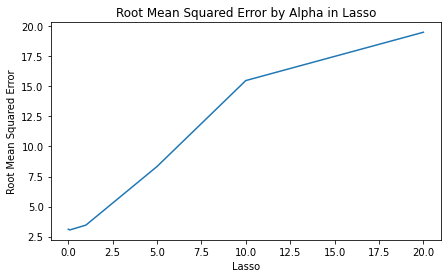

In [8]:
#Want to predict number added to base
y = df_lif.Result_Dif

#X is everything but Result_Dif, Type, Main, Sub, and Boost
X = df_lif.drop(columns = ['Result_Dif', 'Type', 'Main', 'Sub', 'Boost'])

#Split into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = .8, random_state = 0)

#Scale the features
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)

df_coef = coef_change(X_train_scale, y_train, X_val_scale, y_val, X.columns, [.01, .1, 1, 5, 10, 20])
df_coef

Examining the dataframe, it appears that the only features that make a significant difference are Main_Dif, Sub_Dif, and Rarity_Level. When looking at ways to improve the prediction, these features will serve as the base.

# Linear and Polynomial Models

In [9]:
#Tests different degrees of polynomial features on a linear model, then displays error as a graph
def poly_plot(X_train, y_train, X_val, y_val, degree):
    
    #Creates the list of degrees to try and an empty list for errors
    degree_list = list(range(1, degree + 1))
    error_list = []
    
    #Loop through each degree
    for deg in degree_list:
        
        #Create and fits the polynomial features
        poly = PolynomialFeatures(deg)
        X_train_p = poly.fit_transform(X_train)
        X_val_p = poly.transform(X_val)
        
        poly_model = LinearRegression().fit(X_train_p, y_train)
        error_list.append(np.sqrt(mean_squared_error(y_val, poly_model.predict(X_val_p))))
        
    #Graph the errors
    fig, ax = plt.subplots(figsize = (7,4))
    ax.plot(degree_list, error_list);
    plt.title('Root Mean Squared Error by Polynomial Degree')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Root Mean Squared Error')

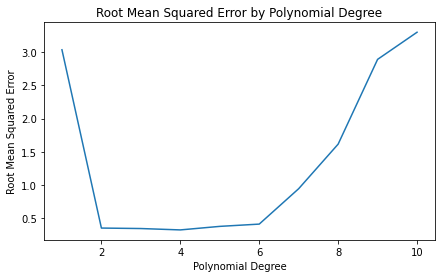

In [10]:
#List features to use
features = ['Main_Dif', 'Sub_Dif', 'Rarity_Level']

#Features and split into same training and validation sets
y = df_lif.Result_Dif
X = df_lif[features]
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = .8, random_state = 0)


poly_plot(X_train, y_train, X_val, y_val, 10)

In [11]:
#Create polynomial features
poly = PolynomialFeatures(2)
X_train_p = poly.fit_transform(X_train)
X_val_p = poly.transform(X_val)

#Scale the polynomial features
scaler = StandardScaler()
X_train_ps = scaler.fit_transform(X_train_p)
X_val_ps = scaler.transform(X_val_p)

#Create and fit model
poly_model = LinearRegression().fit(X_train_ps, y_train)

#List of the coefficient meanings
coefs = ['Intercept', 'Main_Dif', 'Sub_Dif', 'Rarity_Level', 'Main_Dif Squared', 'Main_Dif * Sub_Dif', \
        'Main_Dif * Rarity_Level', 'Sub_Dif Squared', 'Sub_Dif * Rarity_Level', 'Rarity_Level Squared']
model_coef = list(poly_model.coef_)

error = np.sqrt(mean_squared_error(y_val, poly_model.predict(X_val_ps)))
print('The square of the mean squared error for the degree two polynomial model is {0}'.format(error))

#Print the coefficients
for i in range(len(coefs)):
    print('{0}: {1}'.format(coefs[i], model_coef[i]))

The square of the mean squared error for the degree two polynomial model is 0.35254144898599143
Intercept: 0.0
Main_Dif: 20.460238391891274
Sub_Dif: 12.00650571363536
Rarity_Level: -0.13830410111796088
Main_Dif Squared: -0.24917088434697465
Main_Dif * Sub_Dif: 0.030374615319779252
Main_Dif * Rarity_Level: -10.755887375385914
Sub_Dif Squared: 0.24967655054895843
Sub_Dif * Rarity_Level: -5.872949170495219
Rarity_Level Squared: 0.20738177019403325


Since we scaled the features, the coefficients above can help indicate which polynomial features are actually contributing. Main_Dif and Sub_Dif are important, and their products with Rarity_Level appear important as well due to the large coefficients. 

Because there is an underlying formula written by humans, the next step will be to perform the same model fit without scaling, then look at the coefficients of Main_Dif, Sub_Dif, Main_Dif Times Rarity_Level, and Sub_Dif Times Rarity_level. They should be close to nice numbers that a human writing a mathematical formula would use.

In [12]:
#Create polynomial features
poly = PolynomialFeatures(2)
X_train_p = poly.fit_transform(X_train)
X_val_p = poly.transform(X_val)

#Create and fit model
poly_model = LinearRegression().fit(X_train_p, y_train)

#List of the coefficient meanings
coefs = ['Intercept', 'Main_Dif', 'Sub_Dif', 'Rarity_Level', 'Main_Dif Squared', 'Main_Dif * Sub_Dif', \
        'Main_Dif * Rarity_Level', 'Sub_Dif Squared', 'Sub_Dif * Rarity_Level', 'Rarity_Level Squared']
model_coef = list(poly_model.coef_)

error = np.sqrt(mean_squared_error(y_val, poly_model.predict(X_val_p)))
print('The square of the mean squared error for the degree two polynomial model is {0}'.format(error))

#Print the coefficients
for i in range(len(coefs)):
    print('{0}: {1}'.format(coefs[i], model_coef[i]))

The square of the mean squared error for the degree two polynomial model is 0.3525414489859511
Intercept: 0.0
Main_Dif: 0.10096702772752958
Sub_Dif: 0.04901000235561237
Rarity_Level: -0.13171822290825247
Main_Dif Squared: -9.818601100844426e-07
Main_Dif * Sub_Dif: 1.1832829704960801e-07
Main_Dif * Rarity_Level: -0.009940152362961904
Sub_Dif Squared: 8.521725444396444e-07
Sub_Dif * Rarity_Level: -0.005012163014664891
Rarity_Level Squared: 0.02871868453779217


Notice that the coefficients we want are very close to fairly simple fractions. Here they are listed below

* Main_Dif = $\frac{1}{10}$
* Sub_Dif = $\frac{1}{20}$
* Main_Dif*Rarity_Level = $\frac{1}{100}$
* Main_Dif*Rarity_Level = $\frac{1}{200}$

If we take the coefficient of Rarity_Level to be $\frac{1}{10}$ then the formula can be written quite simply as

$$\text{Offspring_Stat_Gain} = \left(\frac{\text{Main_Dif}}{10} + \frac{\text{Sub_Dif}}{20}\right) \left(1 - \frac{\text{Rarity_Level}}{10}  \right).  $$

In the next cell, floor functions are used to make this more accurate. This was determined experimentally.

In [13]:
#General formula for offspring stat boost
def offspring_formula(row):
    #Get features from row
    Main_Dif = row['Main_Dif']
    Sub_Dif = row['Sub_Dif']
    Rarity_Level = row['Rarity_Level']
    
    #Formula
    f = int(Main_Dif/10 + Sub_Dif/20)
    return int(f * (1-  Rarity_Level/10))

In [14]:
np.sqrt(mean_squared_error(y, X.apply(offspring_formula, axis = 1)))

0.2013468165642073

In [15]:
#Check which entries the formula did not guess exactly
predictions = X.apply(offspring_formula, axis = 1)
ind = 0
for entry in y:
    if entry != predictions.iloc[ind]:
        print('True Value: {0}, Predicted_Value: {1}, Difference = {2}'.format(entry, predictions.iloc[ind], predictions.iloc[ind] - entry))
    ind +=1

True Value: 34, Predicted_Value: 35, Difference = 1
True Value: 60, Predicted_Value: 61, Difference = 1
True Value: 28, Predicted_Value: 29, Difference = 1
True Value: 39, Predicted_Value: 40, Difference = 1
True Value: 45, Predicted_Value: 46, Difference = 1
True Value: 28, Predicted_Value: 29, Difference = 1
True Value: 45, Predicted_Value: 46, Difference = 1
True Value: 52, Predicted_Value: 53, Difference = 1
True Value: 52, Predicted_Value: 53, Difference = 1
True Value: 61, Predicted_Value: 62, Difference = 1
True Value: 76, Predicted_Value: 77, Difference = 1
True Value: 87, Predicted_Value: 88, Difference = 1
True Value: 76, Predicted_Value: 77, Difference = 1
True Value: 65, Predicted_Value: 66, Difference = 1
True Value: 76, Predicted_Value: 77, Difference = 1
True Value: 65, Predicted_Value: 66, Difference = 1
True Value: 76, Predicted_Value: 77, Difference = 1
True Value: 65, Predicted_Value: 66, Difference = 1
True Value: 43, Predicted_Value: 44, Difference = 1
True Value: 

The fact that there are only $21$ mistakes, and that all of these mistakes are off by only $1$ gives strong evidence that the formula chosen is the correct one.

Although the formula does not appear to always be correct, its proximity to the correct answer hints that the only difference is either errors in collection of the data or rounding errors. Since rounding is used in the formula itself, it could be that the true formula round at different places or has different rules on rounding.

Rounding errors here don't amount to a large change, so this is considered the "true formula".

# Testing the Other Stats

In previous sections, only data from the Lif stat was used. Now, the data from the remaining five statistics will be combined and used to see if the general formula is accurate across these too.

In [16]:
#Load the other five .csv files
df_pow = pd.read_csv('Pow_Data_1.csv')
df_int = pd.read_csv('Int_Data_1.csv')
df_ski = pd.read_csv('Ski_Data_1.csv')
df_spd = pd.read_csv('Spd_Data_1.csv')
df_def = pd.read_csv('Def_Data_1.csv')

#Combine into a single DataFrame and eliminate duplicates
df_test = pd.concat([df_pow, df_int, df_ski, df_spd, df_def])
df_test.drop_duplicates(inplace = True)

#Add extra columns
df_test = add_columns(df_test)

#Select features
features = ['Main_Dif', 'Sub_Dif', 'Rarity_Level']
y_test = df_test.Result_Dif
X_test = df_test[features]

#Create polynomial versions
X_test_p = poly.transform(X_test)

In [17]:
#Calculate mean squared error for the polynomial model and the predicted formula
poly_error = np.sqrt(mean_squared_error(y_test, poly_model.predict(X_test_p)))
formula_error = np.sqrt(mean_squared_error(y_test, X_test.apply(offspring_formula, axis = 1)))

print('Polynomial Error = {0} \nFormula Error = {1}'.format(poly_error, formula_error))

Polynomial Error = 0.3709056066598666 
Formula Error = 0.16085155024444558


In [21]:
#Check which entries the formula did not guess exactly
predictions = X_test.apply(offspring_formula, axis = 1)
ind = 0
count = 0
for entry in y_test:
    if entry != predictions.iloc[ind]:
        print('True Value: {0}, Predicted_Value: {1}, Difference = {2}'.format(entry, predictions.iloc[ind], predictions.iloc[ind] - entry))
        count += 1
    ind +=1
print('The number of mistakes is {0} out of {1}'.format(count, X_test.shape[0]))

True Value: 46, Predicted_Value: 47, Difference = 1
True Value: 46, Predicted_Value: 47, Difference = 1
True Value: 53, Predicted_Value: 54, Difference = 1
True Value: 53, Predicted_Value: 54, Difference = 1
True Value: 60, Predicted_Value: 61, Difference = 1
True Value: 46, Predicted_Value: 47, Difference = 1
True Value: 60, Predicted_Value: 61, Difference = 1
True Value: 60, Predicted_Value: 61, Difference = 1
True Value: 84, Predicted_Value: 85, Difference = 1
True Value: 63, Predicted_Value: 64, Difference = 1
True Value: 63, Predicted_Value: 64, Difference = 1
True Value: 57, Predicted_Value: 58, Difference = 1
True Value: 76, Predicted_Value: 77, Difference = 1
True Value: 38, Predicted_Value: 39, Difference = 1
True Value: 38, Predicted_Value: 39, Difference = 1
True Value: 38, Predicted_Value: 39, Difference = 1
True Value: 39, Predicted_Value: 40, Difference = 1
True Value: 39, Predicted_Value: 40, Difference = 1
True Value: 59, Predicted_Value: 60, Difference = 1
True Value: 

# Conclusion

Let $[]$ be the integer floor function. Then the formula used can be written as
$$\text{Offspring_Stat_Gain} = \left[\left[\left(\frac{\text{Main_Dif}}{10} + \frac{\text{Sub_Dif}}{20}\right)\right] \left(1 - \frac{\text{Rarity_Level}}{10}  \right) \right].  $$

The only variable that doesn't come directly from the game is the Rarity_Level (so changing that will change the formula). The method we used to convert Rarity into Rarity_Level is given below:

In [38]:
pd.DataFrame({'Rarity': ['1 - 3', '4 - 7', '8 - 14', '15 - 29', '30 - 49', '50+'], 'Rarity_Level': [1,2,3,4,5,6]})

,Rarity,Rarity_Level
0,1 - 3,1
1,4 - 7,2
2,8 - 14,3
3,15 - 29,4
4,30 - 49,5
5,50+,6


There are a few possible explanations for why this formula is usually exact, but not always. First, there could still be a missing term. However, if this is the case, then the term must have an extremely small coefficient since all of the errors are only off by $1$. Another argument against this is the lack of any true pattern in the mistakes. While this is not true proof, it does hint at a different problem. Second, and most likely, there could be a rounding error. The use of floor functions is thrown in to make this more accurate, but it's hard to know the correct place to put them. So far, this is the most accurate placement, but the rounding functions might not be floor functions and they could be placed differently. That would explain why the error is only $1$ off; it's a rounding error. Third, there could be a small mistake in the base stats. This is also not likely. I have only found one mistake in the data collected, and it resulted in a much larger error. Finally, the nature of Rarity_Level could be misunderstood. There's no reason that the gap between these needs to be the same. However, there's not any evidence to support that the levels should be different either.

Due to the infrequency of errors, the fact that these are $1$-off errors, and the very human nature of the formula, I conclude that this is the underlying formula for determining offspring stats when the parent stats do not match. 

The obvious sequel to this project is to attempt to estimate the offspring stats when stat orders match and the random number generator is also used. Determining the effect and range of the random number generator will take lots of extra data collection, so there will likely be a large break before that is tackled.